In [34]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [71]:
df1 = pd.read_csv('archive/lap_times.csv')
df2 = pd.read_csv('archive/races.csv')

In [72]:
#Eldobjuk a position és az ido oszlopot, és millisecond-al dolgozunk
df1 = df1.drop('time', axis=1)
df1 = df1.drop('position', axis=1)
#Eldobjuk a 2010 előtti versenyeket, mivel 2010be tiltották meg a tankolást,
#és az üzemanyag súlya nagyban befolyásolja a köridőt, és így körről körre gyorsabb is lesz az autó, "tanulhatóbb"
df2 = df2[df2['year'] > 2009]
#eldobunk további felesleges oszlopokat
df2 = df2.drop(['round','round','date','time','url','fp1_date','fp1_time','fp2_date','fp2_time','fp3_date','fp3_time','quali_date','quali_time', 'sprint_date', 'sprint_time'], axis=1)

In [73]:
#Az inner-el csak azokat merge-eljük amiknek mind2 táblában van raceId
merged_df = pd.merge(df1, df2, on='raceId', how='inner')

In [74]:
#Leszűkítjük a keresést Hamiltonra, hogy egyszerűbb legyen (már sok driver nincs is a formula 1ben)
Ham = merged_df[(merged_df['driverId'] == 1)]

In [75]:
median = Ham['milliseconds'].median()
print(median)
#Ham = Ham[Ham['milliseconds'] <= median]
Ham['milliseconds'] = np.where(Ham['milliseconds'] > median - 2000, median - 3000, Ham['milliseconds'])

#Kiválasztjuk Monza-t
Ham = Ham[(Ham['circuitId'] == 14)]

92793.0


C:\Users\prokk\AppData\Local\Temp\ipykernel_12124\1193100888.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Ham['milliseconds'] = np.where(Ham['milliseconds'] > median - 2000, median - 3000, Ham['milliseconds'])


In [76]:
#A név oszlopot eltávolítjuk, mert nem szükséges a modellezéshez
Ham = Ham.drop(['name'], axis=1)

#Az adatokat évekre és körökre rendezzük
#Ham = Ham.sort_values(['year', 'lap'])
#Ham = Ham.sort_values(['lap'])
Ham = Ham.sort_values(['lap','year'])

In [77]:
print(Ham)

        raceId  driverId  lap  milliseconds  year  circuitId
15554      853         1    1       89793.0  2011         14
39572      872         1    1       89793.0  2012         14
63118      892         1    1       89793.0  2013         14
86051      912         1    1       89793.0  2014         14
103424     938         1    1       89689.0  2015         14
...        ...       ...  ...           ...   ...        ...
172677     981         1   53       84462.0  2017         14
194288    1002         1   53       86125.0  2018         14
217442    1023         1   53       85982.0  2019         14
233936    1038         1   53       84182.0  2020         14
285609    1089         1   53       89793.0  2022         14

[608 rows x 6 columns]


In [78]:
laps = np.array(Ham['lap'])
milliseconds = np.array(Ham['milliseconds'])
print(laps)
print(milliseconds)

[ 1  1  1  1  1  1  1  1  1  1  1  1  2  2  2  2  2  2  2  2  2  2  2  2
  3  3  3  3  3  3  3  3  3  3  3  3  4  4  4  4  4  4  4  4  4  4  4  4
  5  5  5  5  5  5  5  5  5  5  5  5  6  6  6  6  6  6  6  6  6  6  6  6
  7  7  7  7  7  7  7  7  7  7  7  7  8  8  8  8  8  8  8  8  8  8  8  8
  9  9  9  9  9  9  9  9  9  9  9  9 10 10 10 10 10 10 10 10 10 10 10 10
 11 11 11 11 11 11 11 11 11 11 11 11 12 12 12 12 12 12 12 12 12 12 12 12
 13 13 13 13 13 13 13 13 13 13 13 13 14 14 14 14 14 14 14 14 14 14 14 14
 15 15 15 15 15 15 15 15 15 15 15 15 16 16 16 16 16 16 16 16 16 16 16 16
 17 17 17 17 17 17 17 17 17 17 17 17 18 18 18 18 18 18 18 18 18 18 18 18
 19 19 19 19 19 19 19 19 19 19 19 19 20 20 20 20 20 20 20 20 20 20 20 20
 21 21 21 21 21 21 21 21 21 21 21 21 22 22 22 22 22 22 22 22 22 22 22 22
 23 23 23 23 23 23 23 23 23 23 23 23 24 24 24 24 24 24 24 24 24 24 24 24
 25 25 25 25 25 25 25 25 25 25 25 25 26 26 26 26 26 26 26 26 26 26 26 27
 27 27 27 27 27 27 27 27 27 27 28 28 28 28 28 28 28

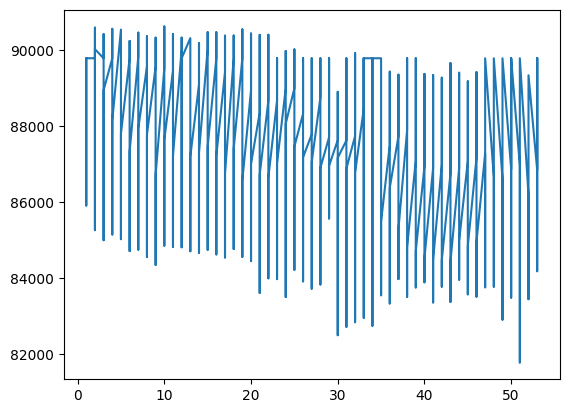

In [79]:
plt.Figure(figsize=(10,6))
plt.plot(laps,milliseconds)

In [ ]:
def lookback(milliseconds,look):
    X = []
    Y = []
    for i in range(0,len(milliseconds)-look):
        X.append(milliseconds[i:i+look])
        Y.append(milliseconds[i+look])
    return np.array(X).reshape(len(X),look,1),np.array(Y)

In [ ]:
x,y = lookback(milliseconds,5)


In [27]:
#A kimeneti változó (y) a köridők lesznek, a bemeneti változók pedig a többi oszlop
y = Ham['milliseconds']
X = Ham.drop(['milliseconds'], axis=1)

#Normalizáljuk az adatokat
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

#Átalakítjuk az adatokat a RNN bemeneti formátumába (minták, időlépések, jellemzők)
X = np.reshape(X, (X.shape[0], 1, X.shape[1]))


In [28]:
# Felosztjuk az adatokat tanuló és teszt halmazokra
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# RNN modell létrehozása
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Modell tanítása
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test), shuffle=False)


Epoch 1/50
16/16 [==============================] - 2s 23ms/step - loss: 7599228928.0000 - val_loss: 7716678656.0000
Epoch 2/50
16/16 [==============================] - 0s 5ms/step - loss: 7599216128.0000 - val_loss: 7716665856.0000
Epoch 3/50
16/16 [==============================] - 0s 6ms/step - loss: 7599202304.0000 - val_loss: 7716649984.0000
Epoch 4/50
16/16 [==============================] - 0s 5ms/step - loss: 7599182848.0000 - val_loss: 7716628480.0000
Epoch 5/50
16/16 [==============================] - 0s 4ms/step - loss: 7599159296.0000 - val_loss: 7716602368.0000
Epoch 6/50
16/16 [==============================] - 0s 5ms/step - loss: 7599129600.0000 - val_loss: 7716569600.0000
Epoch 7/50
16/16 [==============================] - 0s 4ms/step - loss: 7599092224.0000 - val_loss: 7716528640.0000
Epoch 8/50
16/16 [==============================] - 0s 4ms/step - loss: 7599046144.0000 - val_loss: 7716479488.0000
Epoch 9/50
16/16 [==============================] - 0s 5ms/step - loss:

4/4 [==============================] - 0s 2ms/step


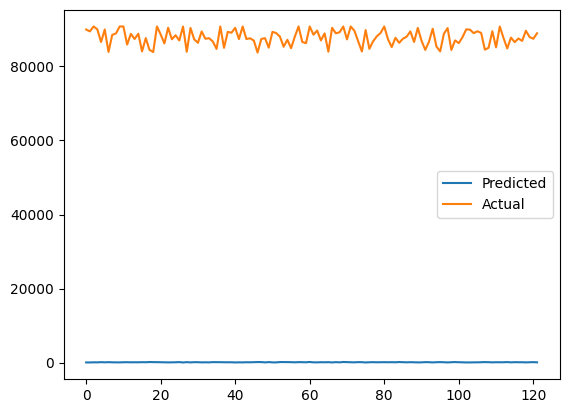

In [29]:
# Az előrejelzés és a valós értékek plotolása
plt.plot(model.predict(X_test), label='Predicted')
plt.plot(y_test.values, label='Actual')
plt.legend()
plt.show()